In [1]:
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import typing
import networkx as nx

# Example 1: Knapsack problem

Given a set of items $I = \{ 1, \dots, {\rm n_{items}}\}$, each $i \in I$ having an associated weight $w_i$ and profit $p_i$,
we want to select the items yielding maximal profit within a weight restriction $W_{\max}$.

$$
\begin{aligned}
\text{Maximize}\
& \sum_{i \in I} p_i x_i
\\
\text{Subject to}\
& \sum_{i \in I} w_i x_i \leq W_{\max}
\\
& x_i \in \{ 0, 1 \}
& \text{for all}\ i \in I
\end{aligned}
$$

In [2]:
# Knapsack problem. Invent some data
random.seed(0)
n_items = 20
max_weight_range = 20
max_profit_range = 20

weights = [random.randint(1, max_weight_range) for _ in range(n_items)]
profits = [random.randint(1, max_profit_range) for _ in range(n_items)]
max_weight = 150  # How much we can pack maximally

print(f"Weights: {weights}")
print(f"Profits: {profits}")
print(f"Maximal weight: {max_weight}")

Weights: [13, 14, 2, 9, 17, 16, 13, 10, 16, 12, 19, 7, 17, 5, 10, 5, 4, 20, 9, 18]
Profits: [20, 5, 10, 4, 3, 11, 16, 18, 4, 12, 14, 11, 20, 7, 18, 16, 15, 17, 9, 2]
Maximal weight: 150


In [3]:
# Create model
model : gp.Model = gp.Model("knapsack")

# Introduce variable x, whether item (i) is included.
x = model.addVars(range(n_items), vtype=gp.GRB.BINARY, name="x")

model.addConstr(
    gp.quicksum(weights[i] * x[i] for i in range(n_items)) <= max_weight
)

model.setObjective(
    gp.quicksum(profits[i] * x[i] for i in range(n_items)),
    sense=gp.GRB.MAXIMIZE
)

Set parameter GURO_PAR_SPECIAL
Set parameter TokenServer to value "TUELICENSE4.campus.tue.nl"


## Solving with default settings

In [4]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0x7f939226
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [2e+00, 2e+01]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 2e+02]
Found heuristic solution: objective 128.0000000
Presolve removed 1 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 203 128 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.030000000000e+02, best bound 2.030000000000e+02, gap 0.0000%


## Solving without Gurobi's ingenuities

With default settings, it is solved during presolving.

In [5]:
# Reset model
model.reset()

# This is purely illustrational. Gurobi already implements such methods, meaning that we do not win anything.
# Tell Gurobi to be "stupid" by disabling many of their ingenuities
model.Params.Cuts = 0
model.Params.Presolve = 0
model.Params.Heuristics = 0
model.Params.Symmetry = 0
model.Params.BranchDir = 1
model.Params.PreCrush = 1  # Needed, see https://www.gurobi.com/documentation/10.0/refman/py_model_cbcut.html


Discarded solution information
Set parameter Cuts to value 0
Set parameter Presolve to value 0
Set parameter Heuristics to value 0
Set parameter Symmetry to value 0
Set parameter BranchDir to value 1
Set parameter PreCrush to value 1


In [6]:
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0x7f939226
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [2e+00, 2e+01]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 2e+02]
Variable types: 0 continuous, 20 integer (20 binary)

Root relaxation: objective 2.057500e+02, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  205.75000    0    1          -  205.75000      -     -    0s
     0     0  205.75000    0    1          -  205.75000      -     -    0s
     0     2  205.75000    0    1 

## Separate cover inequalities

In [7]:
def find_cover_inequality(x : typing.List[gp.Var], x_frac : typing.List[float], max_weight):
    """
    Given a fractional solution x_frac,
    determine violated cover in equality.

    Stupid algorithm: Just try all possible subsets, and give the first violated one that we find.
    """
    for subset_size in range(n_items):
        for subset in itertools.combinations(range(n_items), r=subset_size):
            if sum(weights[i] for i in subset) > max_weight:
                # This is a possible cover!
                if sum(x_frac[i] for i in subset) > subset_size - 1 + 1e-6:  # Allow some slack, add 1e-6.
                    # This is a violated cover!
                    return gp.quicksum(x[i] for i in subset) <= subset_size - 1

    # Did not find one!
    return None


def callback(model, where):
    if where == gp.GRB.Callback.POLLING:
        # Polling callback: This is called every so-many milliseconds.
        return

    if where == gp.GRB.Callback.MIPNODE:
        # MIPNODE callback: A branch-and-bound tree node is solved to optimality
        # Get status
        status = model.cbGet(gp.GRB.Callback.MIPNODE_STATUS)
        if status != gp.GRB.Status.OPTIMAL:
            return

        # Get (fractional) solution
        x_frac = model.cbGetNodeRel(x)

        print()
        print(f"# Solved branch-and-bound tree node to optimality. Search violated cover inequality:")

        # Find a violated cover inequality
        cut = find_cover_inequality(x, x_frac, max_weight)
        if cut is None:
            print("Search is unsuccessful")
            return
        else:
            print(cut)
            model.cbCut(cut)
        return

    if where == gp.GRB.Callback.MIPSOL:
        x_sol = model.cbGetSolution(x)
        # get the solution value; see https://www.gurobi.com/documentation/9.5/refman/cb_codes.html#sec:CallbackCodes
        x_sol_val = model.cbGet(gp.GRB.Callback.MIPSOL_OBJ)

        print()
        print(f"# Found new solution with value {x_sol_val:.2f}")
        items = [i for i in range(n_items) if x_sol[i] > .9]
        for i in range(n_items):
            if x_sol[i] < .5:
                continue
            print(f"{i} (value {x_sol[i]:.1f}, weight {weights[i]}, profit {profits[i]})")
        return

    pass

model.reset()
model.optimize(callback=callback)

Discarded solution information
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0x7f939226
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [2e+00, 2e+01]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 2e+02]
Variable types: 0 continuous, 20 integer (20 binary)

Root relaxation: objective 2.057500e+02, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  205.75000    0    1          -  205.75000      -     -    0s

# Solved branch-and-bound tree node to optimality. Search violated cover ineq

# Example 2: Traveling Salesman Problem

Given a graph $G = (V, E)$, and every edge $\{i, j\} \in E$ having cost $c_{ij}$.

Goal: Find a circuit in $G$ visiting all vertices $V$ traversing edges $C \subseteq E$, such that $\sum_{ij \in C} c_{ij}$ is minimal.

Decision variable: For all $\{i, j\} \in E$, variable $x_{i, j} \in \{ 0, 1 \}$ states whether edge $i, j$ is traversed in the circuit.

$$
\begin{aligned}
\text{minimize}\
& \sum_{ij \in E} c_{ij} x_{ij}& \\
\text{subject to}\
& \sum_{j \in V \setminus \{ i \}} x_{ij} = 2
&& \text{for all}\ i \in V
&& \text{(Enter and exit every vertex once)}
\\
& \sum_{i \in S, j \in V \setminus S} x_{ij} \geq 2
&& \text{for all}\ S \subsetneq V, S \neq \emptyset
&& \text{(No subtours)}
&& (\dagger)
\\
& x \in \{ 0, 1 \}^E
\end{aligned}
$$

Note that $(\dagger)$ is a constraint for all $S \subseteq V$, of which $2^{|V|}-1$ exist.
We do not want to add these constraints in advance. $\leadsto$ SEPARATION

Upper 5 by 5 distance matrix:


array([[0.        , 0.1786471 , 0.14306129, 0.20869372, 0.53118409],
       [0.1786471 , 0.        , 0.20562852, 0.3842079 , 0.39536284],
       [0.14306129, 0.20562852, 0.        , 0.2462733 , 0.60040816],
       [0.20869372, 0.3842079 , 0.2462733 , 0.        , 0.73154383],
       [0.53118409, 0.39536284, 0.60040816, 0.73154383, 0.        ]])

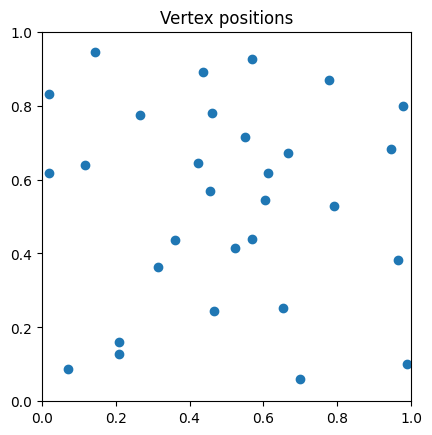

In [8]:
# Fabricate an Euclidean TSP instance.
n_vertices = 30

# Random x and y coordinates
np.random.seed(0)
pos = np.random.rand(n_vertices, 2)
pos_x = pos[:, 0]
pos_y = pos[:, 1]

# Compute Euclidean distances between all coordinate-pairs
dist = np.sqrt(
    np.power(pos_x[:, np.newaxis] - pos_x[np.newaxis, :], 2) +
    np.power(pos_y[:, np.newaxis] - pos_y[np.newaxis, :], 2)
)
print("Upper 5 by 5 distance matrix:")
display(dist[:5, :5])

fig, ax = plt.subplots()
ax.set_title("Vertex positions")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect(1)
ax.scatter(pos_x, pos_y)
plt.show()

In [9]:
model : gp.Model = gp.Model(name="TSP")

# Enable lazy constraints!
# (these are not cutting planes, because subtour elimination constraints
# are not implied by enter/exit neighbour constraints)
model.Params.LazyConstraints = 1

edges = list(itertools.combinations(range(n_vertices), r=2))

# A binary variable for every edge
x = model.addVars(edges, vtype=gp.GRB.BINARY, name="x")

# Neighbour constraints
model.addConstrs(
    constrs=(
        gp.quicksum(var for (i_, j_), var in x.items() if i in [i_, j_]) == 2
        for i in range(n_vertices)
    ),
    name="neighbour"
)

# Set objective
model.setObjective(gp.quicksum(dist[i, j] * var for (i, j), var in x.items()), sense=gp.GRB.MINIMIZE)

# Solve model
model.optimize()

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 30 rows, 435 columns and 870 nonzeros
Model fingerprint: 0x489505fe
Variable types: 0 continuous, 435 integer (435 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 16.2212163
Presolve time: 0.00s
Presolved: 30 rows, 435 columns, 870 nonzeros
Variable types: 0 continuous, 435 integer (435 binary)

Root relaxation: objective 4.674165e+00, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.674

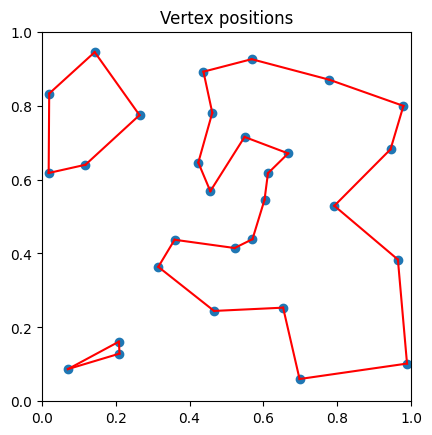

In [10]:
fig, ax = plt.subplots()
ax.set_title("Vertex positions")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect(1)

# Plot solution
for (i, j), var in x.items():
    if var.X > .5:
        # Edge (i, j) is selected!
        ax.plot((pos_x[i], pos_x[j]), (pos_y[i], pos_y[j]), "r")
ax.scatter(pos_x, pos_y)

plt.show()


In [11]:
# Callback.
def callback(model, where):
    # Ignore polling callbacks.
    if where == gp.GRB.Callback.POLLING:
        return

    # A LP-solution got solved during branch-and-bound.
    if where == gp.GRB.Callback.MIPNODE:
        # Ignore (for now?)
        # x_rel = model.cbGetNodeRel(x)
        return

    if where == gp.GRB.Callback.MIPSOL:
        # An integer solution is found!
        # Get the integer solution of our variables x.
        x_sol = model.cbGetSolution(x)

        # Determine if the graph is disconnected.
        g : nx.Graph = nx.Graph()
        g.add_edges_from((i, j) for (i, j), val in x_sol.items() if val > .5)

        connected_components = list(nx.connected_components(g))

        # print(connected_components)

        # We are happy if the graph is connected.
        if len(connected_components) == 1:
            return

        # Graph is not connected
        for S in connected_components[1:]:
            T = set(range(n_vertices))
            T.difference_update(S)
            print(f"Subtour elimination of {S}")
            model.cbLazy(gp.quicksum(x[i, j] for (i, j) in x if ((i in S) ^ (j in S))) >= 2)

model.reset()
model.optimize(callback=callback)

Discarded solution information
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 30 rows, 435 columns and 870 nonzeros
Model fingerprint: 0x489505fe
Variable types: 0 continuous, 435 integer (435 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Subtour elimination of {3, 15, 18, 20, 26}
Presolve time: 0.00s
Presolved: 30 rows, 435 columns, 870 nonzeros
Variable types: 0 continuous, 435 integer (435 binary)
Subtour elimination of {1, 25, 14}
Subtour elimination of {2, 3, 4, 5, 6, 9, 10, 11, 16, 19, 20, 21, 24, 26, 28, 29}
Subtour elimination of {27, 23, 7}
Subtour elimination of {8, 12, 13, 15, 17}
Subtour elimination of {27, 3, 2, 26}
Subtour elimination of {24, 25, 4, 5}
Subt

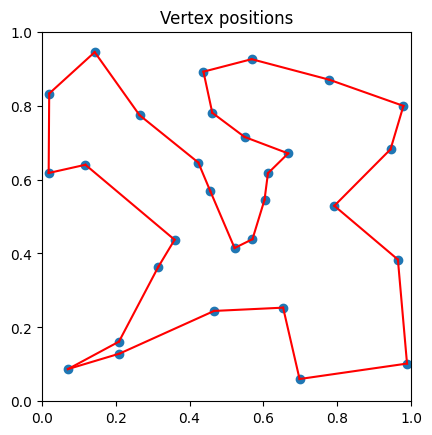

In [12]:
fig, ax = plt.subplots()
ax.set_title("Vertex positions")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect(1)

# Plot solution
for (i, j), var in x.items():
    if var.X > .5:
        # Edge (i, j) is selected!
        ax.plot((pos_x[i], pos_x[j]), (pos_y[i], pos_y[j]), "r")
ax.scatter(pos_x, pos_y)

plt.show()
